## Import Libraries

In [2286]:
import pandas as pd
import os

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
#importear de preprocessing las normalizaciones
from sklearn.preprocessing import Normalizer

#dense transformer
from sklearn.svm import LinearSVC

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

#BAGGING
from sklearn.ensemble import BaggingClassifier

#voting
from sklearn.ensemble import VotingClassifier

#stacking
from sklearn.ensemble import StackingClassifier


#random forest
from sklearn.ensemble import RandomForestRegressor

#LogisticRegression
from sklearn.linear_model import LogisticRegression

#svm 
from sklearn.svm import SVC

from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import GradientBoostingClassifier
#extra trees
from sklearn.ensemble import ExtraTreesClassifier


def csv(predicciones,nombre,df_test):
    y_pred = pd.DataFrame({'id':df_test['id'],'Predicted':predicciones})
    y_pred['Predicted'] = y_pred['Predicted'].astype(int)
    y_pred.to_csv(nombre,index=False)

#oversampling

from imblearn.over_sampling import SMOTE

#gridsearch y kfold
from sklearn.model_selection import GridSearchCV, KFold

import re

#cross_val_score
from sklearn.model_selection import cross_val_score

def simp_transmission(train):
    split_transmission = lambda row: re.split('(\d+)', row)[0]
    train['Transmission'] = train['Transmission'].apply(split_transmission)
    return train



## Load Data

In [2287]:
directorio = '../apau-smog-prediction/'
lista = os.listdir(directorio)
for i in lista:
    exec(i.split('.')[0] + ' = pd.read_csv(directorio + i)')

In [2288]:
smog = train['Smog']
train = train.drop(['id','Comb (L/100 km)','Comb (mpg)','Model','Model Year','Smog'], axis=1)
id =test_nolabel['id']
test_nolabel = test_nolabel.drop(['id','Comb (L/100 km)','Comb (mpg)','Model','Model Year'], axis=1)

In [2289]:
X_train, X_test, y_train, y_test = train_test_split(train, smog, test_size=0.2, random_state=42)

In [2290]:
train

,Make,Vehicle Class,Engine Size (L),Cylinders,Transmission,Fuel Type,Fuel Consumption City (L/100 km),Hwy (L/100 km),CO2 Emissions (g/km)
0,Mercedes-Benz,Station wagon: Small,2.0,4,AM7,Z,10.0,7.0,202
1,Mazda,Mid-size,2.0,4,AS6,X,8.6,6.7,181
2,Porsche,Full-size,2.9,6,AM8,Z,12.8,10.2,274
3,Mazda,Compact,2.0,4,AS6,X,8.6,7.4,189
4,Aston Martin,Minicompact,5.2,12,A8,Z,16.4,10.7,324
...,...,...,...,...,...,...,...,...,...
581,BMW,Mid-size,4.4,8,AS8,Z,16.1,11.0,322
582,Dodge,Full-size,5.7,8,A8,X,14.7,9.4,289
583,Ram,Pickup truck: Standard,3.0,6,A8,D,11.1,8.0,260
584,Honda,Full-size,2.0,4,AS10,X,10.4,7.4,211


In [2291]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 586 entries, 0 to 585
Data columns (total 9 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Make                              586 non-null    object 
 1   Vehicle Class                     586 non-null    object 
 2   Engine Size (L)                   586 non-null    float64
 3   Cylinders                         586 non-null    int64  
 4   Transmission                      586 non-null    object 
 5   Fuel Type                         586 non-null    object 
 6   Fuel Consumption City (L/100 km)  586 non-null    float64
 7   Hwy (L/100 km)                    586 non-null    float64
 8   CO2 Emissions (g/km)              586 non-null    int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 41.3+ KB


In [2292]:
#oversampled train importar SMOTE
#SMOTENC
from imblearn.over_sampling import SMOTENC
import numpy as np

r = np.random.randint(0,100)
sm = SMOTENC(random_state=r, categorical_features=[0,1,4,5], sampling_strategy='minority', k_neighbors=5)
train, smog = sm.fit_resample(train, smog)

print(r)

16


In [2293]:
smog

0      2
1      4
2      2
3      1
4      1
      ..
745    0
746    0
747    0
748    0
749    0
Name: Smog, Length: 750, dtype: int64

(array([197.,   0., 125.,   0.,   0., 197.,   0., 112.,   0., 119.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

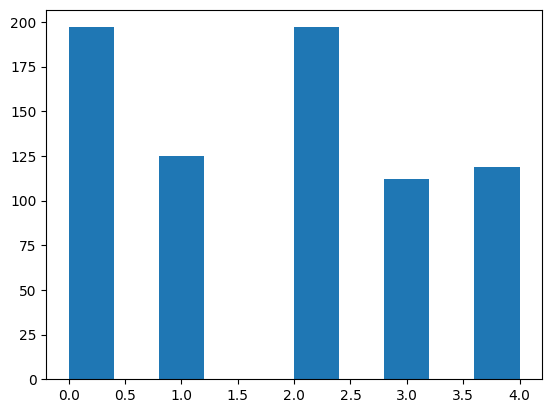

In [2294]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.hist(smog)

In [2295]:
comprobar = pd.read_csv('comprobar.csv')

In [2296]:
comprobar_test =comprobar.iloc[186:,:]

In [2297]:
cat_cols = train.select_dtypes(include="object").columns.tolist()
num_cols = train.select_dtypes(exclude="object").columns.tolist()

cat_pipe = Pipeline([
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

num_pipe = Pipeline([
    ("scaler", StandardScaler())
])
norm_pipe = Pipeline([
    ("norm", Normalizer())
])

preprocessor = ColumnTransformer([
    ("cat", cat_pipe, cat_cols),
    ("num", num_pipe, num_cols)
])

preprocessor_norm = ColumnTransformer([
    ("cat", cat_pipe, cat_cols),
    ("num", norm_pipe, num_cols),
    ("norm", norm_pipe, num_cols)
])


In [2298]:
dict_peso = {
    0:1,
    1:1,
    2:1,
    3:1,
    4:1,
}


rf = Pipeline([
    ("pre", preprocessor),
    ("rf",RandomForestClassifier(random_state=42,class_weight='balanced'))
])

gb = Pipeline([
    ("pre", preprocessor),
    ("gb",GradientBoostingClassifier(random_state=42))
])

ExtraTreesClassifier = Pipeline([
    ("pre", preprocessor),
    ("extra",ExtraTreesClassifier(random_state=42,class_weight='balanced'))
])

svc = Pipeline([
    ("pre", preprocessor),
    ("svc", SVC(random_state=42,C=4,gamma=0.7))
])

In [2304]:
estimators = [
    ('rf',rf),
    ('svc',svc),
    ('extra',ExtraTreesClassifier)
]
stacking = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(solver='liblinear',class_weight='balanced'))

In [2305]:
stacking.fit(train,smog)

StackingClassifier(estimators=[('rf',
                                Pipeline(steps=[('pre',
                                                 ColumnTransformer(transformers=[('cat',
                                                                                  Pipeline(steps=[('ohe',
                                                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                                                  ['Make',
                                                                                   'Vehicle '
                                                                                   'Class',
                                                                                   'Transmission',
                                                                                   'Fuel '
                                                                                   'Type']),
                                                                                 ('num',
                                                                                  Pipeline(steps=[('scaler',
                                                                                                   StandardScaler())]),
                                                                                  ['Engine '
                                                                                   'Size '
                                                                                   '(L)',
                                                                                   'Cylinders',
                                                                                   'Fuel '
                                                                                   'Consumption '
                                                                                   'City '
                                                                                   '(L/100 '
                                                                                   'km)',
                                                                                   'Hwy '
                                                                                   '...
                                                                                   'Transmission',
                                                                                   'Fuel '
                                                                                   'Type']),
                                                                                 ('num',
                                                                                  Pipeline(steps=[('scaler',
                                                                                                   StandardScaler())]),
                                                                                  ['Engine '
                                                                                   'Size '
                                                                                   '(L)',
                                                                                   'Cylinders',
                                                                                   'Fuel '
                                                                                   'Consumption '
                                                                                   'City '
                                                                                   '(L/100 '
                                                                                   'km)',
                                                                                   'Hwy '
                                                                                   '(L/100 '
                                                               

In [2306]:
scores = cross_val_score(stacking, train, smog, cv=8, scoring='f1_macro')
scores

array([0.79751746, 0.86080725, 0.82384771, 0.84353448, 0.84537049,
       0.9128683 , 0.87025469, 0.75217129])

In [2307]:
f1_score(comprobar['Predicted'],stacking.predict(test_nolabel),average='macro')


0.8763136525138691

In [2308]:
f1_score(comprobar_test['Predicted'],stacking.predict(test_nolabel.iloc[186:]),average='macro')

0.8703469554253503

In [2309]:
f1_score(comprobar.iloc[0:186]['Predicted'],stacking.predict(test_nolabel.iloc[0:186]),average='macro')

0.8823379556848666

In [2283]:
0.887790801-(0.90026-0.896605432870)

0.8841362338700001

In [2281]:
test = test_nolabel.copy()
test['id'] = id
csv(stacking.predict(test_nolabel),'predicciones_stacking.csv',test)

In [2089]:
test = test_nolabel.copy()
test['id'] = id
csv(stacking.predict(test_nolabel),'stacking_rf_svc_extra.csv',test)

Arboles de decisión

NotFittedError: This ColumnTransformer instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [1139]:
csv(predictions,'extra_tree.csv',test)

Random Forest

In [1137]:
from sklearn.linear_model import Lasso, Ridge, ElasticNet
#functiontransformer
from sklearn.preprocessing import FunctionTransformer
#cross validation
from sklearn.model_selection import cross_val_score, cross_val_predict
#extratrees
from sklearn.ensemble import ExtraTreesClassifier

rf = Pipeline([
    ("preprocessor", preprocessor),
    ("rf", ExtraTreesClassifier(n_estimators=100, random_state=42,class_weight='balanced'))
])

predictions = cross_val_predict(rf, train, smog, cv=5)
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
print(classification_report(smog, predictions))
print(f1_score(y_test, y_pred, average='macro'))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94        33
           1       0.81      0.76      0.78       125
           2       0.80      0.81      0.81       197
           3       0.86      0.85      0.86       112
           4       0.74      0.77      0.75       119

    accuracy                           0.81       586
   macro avg       0.83      0.83      0.83       586
weighted avg       0.81      0.81      0.81       586

0.8127417142492585


In [1317]:
gd_rf = GridSearchCV(rf, param_grid={'rf__n_estimators': [100, 200, 300, 400, 500],'rf__criterion':['gini','entropy']}, cv=5,verbose=3)

In [1318]:
gd_rf.fit(train,smog)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END rf__criterion=gini, rf__n_estimators=100;, score=0.814 total time=   0.4s
[CV 2/5] END rf__criterion=gini, rf__n_estimators=100;, score=0.829 total time=   0.6s
[CV 3/5] END rf__criterion=gini, rf__n_estimators=100;, score=0.821 total time=   0.5s
[CV 4/5] END rf__criterion=gini, rf__n_estimators=100;, score=0.846 total time=   0.4s
[CV 5/5] END rf__criterion=gini, rf__n_estimators=100;, score=0.718 total time=   0.4s
[CV 1/5] END rf__criterion=gini, rf__n_estimators=200;, score=0.831 total time=   0.9s
[CV 2/5] END rf__criterion=gini, rf__n_estimators=200;, score=0.829 total time=   0.9s
[CV 3/5] END rf__criterion=gini, rf__n_estimators=200;, score=0.829 total time=   1.3s
[CV 4/5] END rf__criterion=gini, rf__n_estimators=200;, score=0.838 total time=   1.0s
[CV 5/5] END rf__criterion=gini, rf__n_estimators=200;, score=0.718 total time=   0.9s
[CV 1/5] END rf__criterion=gini, rf__n_estimators=300;, score=0.831 t

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Make',
                                                                          'Vehicle '
                                                                          'Class',
                                                                          'Transmission',
                                                                          'Fuel '
                                                                          'Type']),
                                                                        ('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Engine '
                                                                          'Size '
                                                                          '(L)',
                                                                          'Cylinders',
                                                                          'Fuel '
                                                                          'Consumption '
                                                                          'City '
                                                                          '(L/100 '
                                                                          'km)',
                                                                          'Hwy '
                                                                          '(L/100 '
                                                                          'km)',
                                                                          'CO2 '
                                                                          'Emissions '
                                                                          '(g/km)'])])),
                                       ('rf',
                                        RandomForestClassifier(class_weight='balanced',
                                                               random_state=42))]),
             param_grid={'rf__criterion': ['gini', 'entropy'],
                         'rf__n_estimators': [100, 200, 300, 400, 500]},
             verbose=3)

In [1321]:
gd_rf.best_score_


0.8156598580327394

In [1154]:
#bagging
from sklearn.ensemble import BaggingClassifier
#bagging con rf
bagging =Pipeline([
    ("preprocessor", preprocessor),
    ("bagging", BaggingClassifier(base_estimator=ExtraTreesClassifier(class_weight='balanced',n_estimators=100),n_estimators=10, random_state=42))
])

In [1148]:
bagging.fit(train,smog)

c:\Users\andre\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Make', 'Vehicle Class',
                                                   'Transmission',
                                                   'Fuel Type']),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Engine Size (L)',
                                                   'Cylinders',
                                                   'Fuel Consumption City '
                                                   '(L/100 km)',
                                                   'Hwy (L/100 km)',
                                                   'CO2 Emissions (g/km)'])])),
                ('bagging',
                 BaggingClassifier(base_estimator=ExtraTreesClassifier(class_weight='balanced'),
                                   random_state=42))])

In [1155]:
#como ver si el modelo esta overfiteado
#importar cross_val_score
from sklearn.model_selection import cross_val_score

#aplicar cross_val_score
scores = cross_val_score(bagging, train, smog, cv=5, scoring='f1_macro')

c:\Users\andre\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\andre\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\andre\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\andre\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\andre\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWar

In [1156]:
scores#el valor masl alto con el mas pequeño se lleva 0.1 de diferencia, no esta overfiteado

array([0.86317958, 0.83478339, 0.82705452, 0.87810978, 0.76628114])

In [1157]:
rf_1 = Pipeline([
    ("preprocessor", preprocessor),
    ("rf",RandomForestClassifier(n_estimators=100, random_state=42,class_weight='balanced'))
])

In [1158]:
bagging_1 =BaggingClassifier(base_estimator=rf_1,n_estimators=10, random_state=42)

In [1159]:
#satacking
from sklearn.ensemble import StackingClassifier

stack = StackingClassifier(estimators=[('bagging', bagging), ('bagging_1', bagging)], final_estimator=LogisticRegression())

In [1160]:
stack.fit(train,smog)

c:\Users\andre\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\andre\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\andre\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\andre\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\andre\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWar

StackingClassifier(estimators=[('bagging',
                                Pipeline(steps=[('preprocessor',
                                                 ColumnTransformer(transformers=[('cat',
                                                                                  Pipeline(steps=[('ohe',
                                                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                                                  ['Make',
                                                                                   'Vehicle '
                                                                                   'Class',
                                                                                   'Transmission',
                                                                                   'Fuel '
                                                                                   'Type']),
                                                                                 ('num',
                                                                                  Pipeline(steps=[('scaler',
                                                                                                   StandardScaler())]),
                                                                                  ['Engine '
                                                                                   'Size '
                                                                                   '(L)',
                                                                                   'Cylinders',
                                                                                   'Fuel '
                                                                                   'Consumption '
                                                                                   'City '
                                                                                   '(L/10...
                                                                                   'Transmission',
                                                                                   'Fuel '
                                                                                   'Type']),
                                                                                 ('num',
                                                                                  Pipeline(steps=[('scaler',
                                                                                                   StandardScaler())]),
                                                                                  ['Engine '
                                                                                   'Size '
                                                                                   '(L)',
                                                                                   'Cylinders',
                                                                                   'Fuel '
                                                                                   'Consumption '
                                                                                   'City '
                                                                                   '(L/100 '
                                                                                   'km)',
                                                                                   'Hwy '
                                                                                   '(L/100 '
                                                                                   'km)',
                                                                                   'CO2 '
                                                                                   'Emissions '
                                         

In [1162]:
scores = cross_val_score(stack, train, smog, cv=2, scoring='f1_macro')

c:\Users\andre\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\andre\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\andre\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\andre\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\andre\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWar

In [1163]:
scores

array([0.73455624, 0.754286  ])

In [1135]:
#bagging
from sklearn.ensemble import BaggingClassifier
bagging = Pipeline([
    ("preprocessor", preprocessor),
    ("bagging", BaggingClassifier(n_estimators=100, random_state=42,class_weight='balanced'))
])

#al pipeline sel puede añadri un clasificador

TypeError: __init__() got an unexpected keyword argument 'class_weight'

In [1133]:
bagging.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Make', 'Vehicle Class',
                                                   'Transmission',
                                                   'Fuel Type']),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Engine Size (L)',
                                                   'Cylinders',
                                                   'Fuel Consumption City '
                                                   '(L/100 km)',
                                                   'Hwy (L/100 km)',
                                                   'CO2 Emissions (g/km)'])])),
                ('bagging',
                 BaggingClassifier(n_estimators=100, random_state=42))])

In [1134]:
f1_score(y_test, bagging.predict(X_test), average='macro')
print(classification_report(smog, bagging.predict(train)))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99        33
           1       0.96      0.92      0.94       125
           2       0.93      0.94      0.93       197
           3       0.97      0.95      0.96       112
           4       0.93      0.97      0.95       119

    accuracy                           0.95       586
   macro avg       0.95      0.95      0.95       586
weighted avg       0.95      0.95      0.95       586



In [1131]:
predictions = bagging.predict(test_nolabel)

In [1132]:
test = test_nolabel.copy()
test['id'] = id
csv(predictions,'bagging_definitvo.csv',test)

In [1120]:
predictions = rf.predict(test_nolabel)

In [1121]:
test = test_nolabel.copy()
test['id'] = id
csv(predictions,'extra_tree.csv',test)

In [929]:
#nombre de los parametros que generalicen mejor el modelo: 

gd_rf = GridSearchCV(rf, {"rf__n_estimators": [100, 200, 300, 400, 500],"rf__max_depth": [5, 10, 15, 20, 25]}, cv=5, n_jobs=-1)

In [933]:
gd_rf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Make',
                                                                          'Vehicle '
                                                                          'Class',
                                                                          'Transmission',
                                                                          'Fuel '
                                                                          'Type']),
                                                                        ('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Engine '
                                                                          'Size '
                                                                          '(L)',
                                                                          'Cylinders',
                                                                          'Fuel '
                                                                          'Consumption '
                                                                          'City '
                                                                          '(L/100 '
                                                                          'km)',
                                                                          'Hwy '
                                                                          '(L/100 '
                                                                          'km)',
                                                                          'CO2 '
                                                                          'Emissions '
                                                                          '(g/km)'])])),
                                       ('rf',
                                        RandomForestClassifier(class_weight='balanced',
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'rf__max_depth': [5, 10, 15, 20, 25],
                         'rf__n_estimators': [100, 200, 300, 400, 500]})

In [936]:
print(classification_report(y_test, gd_rf.predict(X_test)))
print(f1_score(y_test, gd_rf.predict(X_test), average='macro'))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       0.75      0.69      0.72        26
           2       0.74      0.67      0.71        43
           3       0.78      0.78      0.78        23
           4       0.72      0.91      0.81        23

    accuracy                           0.75       118
   macro avg       0.80      0.81      0.80       118
weighted avg       0.76      0.75      0.75       118

0.8035236153030427


In [1076]:
#gradient boosting
from sklearn.ensemble import GradientBoostingClassifier

gb = Pipeline([
    ("preprocessor", preprocessor),
    ("gb", GradientBoostingClassifier(random_state=42))
])

predictions = cross_val_predict(gb, train, smog, cv=5)
print(classification_report(smog, predictions))

              precision    recall  f1-score   support

           0       0.85      0.67      0.75        33
           1       0.77      0.67      0.72       125
           2       0.62      0.72      0.67       197
           3       0.77      0.68      0.72       112
           4       0.72      0.76      0.74       119

    accuracy                           0.71       586
   macro avg       0.75      0.70      0.72       586
weighted avg       0.72      0.71      0.71       586



In [1077]:
#xgboost
from xgboost import XGBClassifier

xgb = Pipeline([
    ("preprocessor", preprocessor),
    ("xgb", XGBClassifier(random_state=42))
])

predictions = cross_val_predict(xgb, train, smog, cv=5)
print(classification_report(smog, predictions))

              precision    recall  f1-score   support

           0       0.88      0.91      0.90        33
           1       0.74      0.70      0.72       125
           2       0.76      0.76      0.76       197
           3       0.86      0.81      0.83       112
           4       0.69      0.76      0.73       119

    accuracy                           0.77       586
   macro avg       0.79      0.79      0.79       586
weighted avg       0.77      0.77      0.77       586



In [424]:
gd_rf.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\andre\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Make',
                                                                          'Vehicle '
                                                                          'Class',
                                                                          'Transmission',
                                                                          'Fuel '
                                                                          'Type']),
                                                                        ('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Engine '
                                                                          'Size '
                                                                          '(L)',
                                                                          'Cylinders',...
                                                                          'Consumption '
                                                                          'City '
                                                                          '(L/100 '
                                                                          'km)',
                                                                          'Hwy '
                                                                          '(L/100 '
                                                                          'km)',
                                                                          'CO2 '
                                                                          'Emissions '
                                                                          '(g/km)']),
                                                                        ('norm',
                                                                         Pipeline(steps=[('norm',
                                                                                          Normalizer())]),
                                                                         ['Engine '
                                                                          'Size '
                                                                          '(L)',
                                                                          'Cylinders',
                                                                          'Fuel '
                                                                          'Consumption '
                                                                          'City '
                                                                          '(L/100 '
                                                                          'km)',
                                                                          'Hwy '
                                                                          '(L/100 '
                                                                          'km)',
                                                                          'CO2 '
                                                                          'Emissions '
                                                                          '(g/km)'])])),
                                       ('rf', RandomFores

In [425]:
f1_score(y_test, gd_rf.predict(X_test), average='macro')

0.7415991140642303

Transformacíón geométrica

In [1078]:
svm = Pipeline([
    ("preprocessor", preprocessor),
    ("svm", SVC(class_weight='balanced', random_state=42)),
])
predictions = cross_val_predict(svm, train, smog, cv=5)
print(classification_report(smog, predictions))


              precision    recall  f1-score   support

           0       0.89      0.94      0.91        33
           1       0.79      0.70      0.75       125
           2       0.77      0.56      0.65       197
           3       0.79      0.75      0.77       112
           4       0.55      0.88      0.68       119

    accuracy                           0.71       586
   macro avg       0.76      0.77      0.75       586
weighted avg       0.74      0.71      0.71       586



In [943]:
gd_svm.fit(X_train, y_train)

c:\Users\andre\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
10 fits failed out of a total of 70.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\andre\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\andre\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\Users\andre\AppData\Local\Programs\Python\Python39\lib\site-p

GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Make',
                                                                          'Vehicle '
                                                                          'Class',
                                                                          'Transmission',
                                                                          'Fuel '
                                                                          'Type']),
                                                                        ('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Engine '
                                                                          'Size '
                                                                          '(L)',
                                                                          'Cylinders',
                                                                          'Fuel '
                                                                          'Consumption '
                                                                          'City '
                                                                          '(L/100 '
                                                                          'km)',
                                                                          'Hwy '
                                                                          '(L/100 '
                                                                          'km)',
                                                                          'CO2 '
                                                                          'Emissions '
                                                                          '(g/km)'])])),
                                       ('svm',
                                        SVC(class_weight='balanced',
                                            random_state=42))]),
             param_grid={'svm__C': [0, 1, 2, 3, 4, 5, 6]}, scoring='f1_macro')

In [944]:
f1_score(y_test, gd_svm.predict(X_test), average='macro')

0.7676791254842591

In [988]:
#KNN
from sklearn.neighbors import KNeighborsClassifier
KNN = Pipeline([
    ("preprocessor", preprocessor),
    ("knn", KNeighborsClassifier()),
])

predictions = cross_val_predict(KNN, train, smog, cv=5)
print(classification_report(smog, predictions))



              precision    recall  f1-score   support

           0       0.75      0.73      0.74        33
           1       0.69      0.66      0.67       125
           2       0.69      0.69      0.69       197
           3       0.76      0.77      0.76       112
           4       0.65      0.69      0.67       119

    accuracy                           0.70       586
   macro avg       0.71      0.71      0.71       586
weighted avg       0.70      0.70      0.70       586



In [989]:
#mas transformaciones geometricas
from sklearn.preprocessing import PolynomialFeatures
poly = Pipeline([
    ("preprocessor", preprocessor),
    ("poly", PolynomialFeatures(degree=2)),
    ("lr", LogisticRegression())
])

poly.fit(X_train, y_train)

c:\Users\andre\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Make', 'Vehicle Class',
                                                   'Transmission',
                                                   'Fuel Type']),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Engine Size (L)',
                                                   'Cylinders',
                                                   'Fuel Consumption City '
                                                   '(L/100 km)',
                                                   'Hwy (L/100 km)',
                                                   'CO2 Emissions (g/km)'])])),
                ('poly', PolynomialFeatures()), ('lr', LogisticRegression())])

In [956]:
f1_score(y_test, poly.predict(X_test), average='macro')

0.7727898949842109

Gaussian Naive Bayes

In [959]:
train_dummies = pd.get_dummies(train)
test_dummies = pd.get_dummies(test_nolabel)

In [960]:
#que aparecezcan las mismas columnas en train y test
train_dummies, test_dummies = train_dummies.align(test_dummies, join='left', axis=1)

In [962]:
gnb = GaussianNB()
gnb.fit(train_dummies, smog)

GaussianNB()

In [964]:
def standard_scale(df):
    '''Devuelve un dataframe con las columnas escaladas'''
    scaler = StandardScaler()
    string = df.select_dtypes(include=['object']).columns #solo vamos a escalar las columnas que no son string
    df_no_string = df.drop(string,axis=1)
    df_no_string = scaler.fit_transform(df_no_string)
    df_no_string = pd.DataFrame(df_no_string,columns=df.drop(string,axis=1).columns)
    df_escaled = df.copy()
    df_escaled[df_no_string.columns] = df_no_string
    return df_escaled

train_escaled = standard_scale(train)
test_escaled = standard_scale(test_nolabel)

In [965]:
train_dummies = pd.get_dummies(train)
test_dummies = pd.get_dummies(test_nolabel)

In [966]:
train_dummies, test_dummies = train_dummies.align(test_dummies, join='left', axis=1)

In [969]:
gnb = GaussianNB()
gnb.fit(train_dummies, smog, sample_weight=[1.5 if i==0 else 1 for i in smog])
f1_score(smog, gnb.predict(train_dummies), average='macro')

0.6114565413658589

Stacking, Bagging, Boosting y Voting


Stacking

In [1079]:
#stacking
from sklearn.ensemble import StackingClassifier

#DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier
estimators = [
    ('rf', rf),
    ('svm', svm),
    ('knn', KNN)
]
estimators_1 = [
    ('rf', rf),
    ('svm', svm),
    ('knn', KNN)
]
#para el estimador final se puede usar un random forest
stack = StackingClassifier(estimators=estimators, final_estimator=DecisionTreeClassifier())
stack1 = StackingClassifier(estimators=estimators_1, final_estimator=DecisionTreeClassifier())

stack.fit(train, smog)

StackingClassifier(estimators=[('rf',
                                Pipeline(steps=[('preprocessor',
                                                 ColumnTransformer(transformers=[('cat',
                                                                                  Pipeline(steps=[('ohe',
                                                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                                                  ['Make',
                                                                                   'Model',
                                                                                   'Vehicle '
                                                                                   'Class',
                                                                                   'Transmission',
                                                                                   'Fuel '
                                                                                   'Type']),
                                                                                 ('num',
                                                                                  Pipeline(steps=[('scaler',
                                                                                                   StandardScaler())]),
                                                                                  ['Model '
                                                                                   'Year',
                                                                                   'Engine '
                                                                                   'Size '
                                                                                   '(L)',
                                                                                   'Cylinders',
                                                                                   'Fuel '
                                                                                   'Consump...
                                                                                  Pipeline(steps=[('ohe',
                                                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                                                  ['Make',
                                                                                   'Vehicle '
                                                                                   'Class',
                                                                                   'Transmission',
                                                                                   'Fuel '
                                                                                   'Type']),
                                                                                 ('num',
                                                                                  Pipeline(steps=[('scaler',
                                                                                                   StandardScaler())]),
                                                                                  ['Engine '
                                                                                   'Size '
                                                                                   '(L)',
                                                                                   'Cylinders',
                                                                                   'Fuel '
                                                                                   'Consumption '
                                                                                   'City '
                                                                           

In [1035]:
f1_score(y_test, stack.predict(X_test), average='macro')

0.9546350725298094

voting

In [1080]:
#voting
from sklearn.ensemble import VotingClassifier
estimators = [
    ('rf', rf),
    ('svm', svm),
    ('gb', gb),
    ('knn', KNN),
    ('xgb', xgb),
    ('poly', poly)

]
#para el estimador final se puede usar un random forest
voting = VotingClassifier(estimators=estimators, voting='hard', weights=[5,5,4,2,2,3])

In [1081]:
voting.fit(train, smog)

c:\Users\andre\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


VotingClassifier(estimators=[('rf',
                              Pipeline(steps=[('preprocessor',
                                               ColumnTransformer(transformers=[('cat',
                                                                                Pipeline(steps=[('ohe',
                                                                                                 OneHotEncoder(handle_unknown='ignore'))]),
                                                                                ['Make',
                                                                                 'Model',
                                                                                 'Vehicle '
                                                                                 'Class',
                                                                                 'Transmission',
                                                                                 'Fuel '
                                                                                 'Type']),
                                                                               ('num',
                                                                                Pipeline(steps=[('scaler',
                                                                                                 StandardScaler())]),
                                                                                ['Model '
                                                                                 'Year',
                                                                                 'Engine '
                                                                                 'Size '
                                                                                 '(L)',
                                                                                 'Cylinders',
                                                                                 'Fuel '
                                                                                 'Consumpti...
                                                                                                 OneHotEncoder(handle_unknown='ignore'))]),
                                                                                ['Make',
                                                                                 'Vehicle '
                                                                                 'Class',
                                                                                 'Transmission',
                                                                                 'Fuel '
                                                                                 'Type']),
                                                                               ('num',
                                                                                Pipeline(steps=[('scaler',
                                                                                                 StandardScaler())]),
                                                                                ['Engine '
                                                                                 'Size '
                                                                                 '(L)',
                                                                                 'Cylinders',
                                                                                 'Fuel '
                                                                                 'Consumption '
                                                                                 'City '
                                                                                 '(L/100 '
                                                                                 'km)',
                                                                                

In [1082]:
f1_score(y_test, voting.predict(X_test), average='macro')

1.0

In [1083]:
test = test_nolabel.copy()
test['id'] = id
predictions = voting.predict(test_nolabel)
csv(predictions,'voting_todo.csv',test)

bagging

In [1033]:
#la libreria d pasting es la misma que la de bagging
from sklearn.ensemble import PastingClassifier

pasting = PastingClassifier(estimators=estimators, n_jobs=-1)


ImportError: cannot import name 'PastingClassifier' from 'sklearn.ensemble' (c:\Users\andre\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\__init__.py)

In [1068]:
predictions = voting.predict(test_nolabel)

In [1069]:
test = test_nolabel.copy()
test['id'] = id
csv(predictions,'voting3.csv',test)

In [907]:
#quiero combinar todos los knn, svm y random forest para ello voy a hacer un voting classifier o un stacking classifier
from sklearn.ensemble import StackingClassifier
#boosting
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
#XGBClassifier
from xgboost import XGBClassifier

ada = Pipeline([
    ("preprocessor", preprocessor),
    ("ada", GradientBoostingClassifier()),
])  

#PARAMETROS DE GRADIEN BOOSTING QUE regularizan: 
#n_estimators: numero de arboles: cuantos mas arboles mas complejo es el modelo y menos generaliza un buen numero es 100 ya 
#learning_rate: cuanto mas pequeño mas robusto es el modelo, mas robusto sig

gd_ada = GridSearchCV(ada, param_grid={"ada__n_estimators":[100,200],"ada__max_depth":[2,3]},cv=cv, scoring="f1_macro")
gd_svm = GridSearchCV(svm, param_grid={"svm__C":[0.01]},cv=cv, scoring="f1_macro")#para un C ma


estimators = [
    ('svm', svm),
    ('ada', rf)
]

#KNN
from sklearn.neighbors import KNeighborsClassifier

#kfold blending
from sklearn.model_selection import KFold

#stacking con k
from sklearn.ensemble import StackingClassifier

#k
k = 5
#kfold
kf = KFold(n_splits=k, shuffle=True, random_state=42)



clf_1 = StackingClassifier( estimators=estimators, final_estimator=LogisticRegression(),cv=kf, n_jobs=-1)



In [908]:
clf_1.fit(X_train, y_train)

c:\Users\andre\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


StackingClassifier(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                   estimators=[('svm',
                                Pipeline(steps=[('preprocessor',
                                                 ColumnTransformer(transformers=[('cat',
                                                                                  Pipeline(steps=[('ohe',
                                                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                                                  ['Vehicle '
                                                                                   'Class',
                                                                                   'Transmission',
                                                                                   'Fuel '
                                                                                   'Type']),
                                                                                 ('num',
                                                                                  Pipeline(steps=[('scaler',
                                                                                                   StandardScaler())]),
                                                                                  ['Engine '
                                                                                   'Size '
                                                                                   '(L)',
                                                                                   'Cyl...
                                                                                   '(L/100 '
                                                                                   'km)',
                                                                                   'Hwy '
                                                                                   '(L/100 '
                                                                                   'km)',
                                                                                   'CO2 '
                                                                                   'Emissions '
                                                                                   '(g/km)']),
                                                                                 ('norm',
                                                                                  Pipeline(steps=[('norm',
                                                                                                   Normalizer())]),
                                                                                  ['Engine '
                                                                                   'Size '
                                                                                   '(L)',
                                                                                   'Cylinders',
                                                                                   'Fuel '
                                                                                   'Consumption '
                                                                                   'City '
                                                                                   '(L/100 '
                                                                                   'km)',
                                                                                   'Hwy '
                                                                                   '(L/100 '
                                                                                   'km)',
                                                                                   'CO2 '
                                                                                   'Emiss

In [909]:
predictions = clf_1.predict(X_test)

In [910]:
f1_score(y_test, predictions, average='macro')

0.7671836564519492

In [769]:
confusion_matrix(smog, predictions)

array([[ 33,   0,   0,   0,   0],
       [  0, 124,   0,   0,   1],
       [  0,   0, 197,   0,   0],
       [  0,   0,   1, 111,   0],
       [  0,   0,   0,   0, 119]], dtype=int64)

In [764]:
predictions = clf_1.predict(test_nolabel)

In [766]:
test = test_nolabel.copy()
test['id'] = id
csv(predictions,'rf_svm_logreg_2.csv',test)

In [631]:
clf_1.fit(X_train,y_train)#para el stacking: train, smog, para el voting: X_train, y_train 


StackingClassifier(cv=KFold(n_splits=10, random_state=42, shuffle=True),
                   estimators=[('svm',
                                Pipeline(steps=[('preprocessor',
                                                 ColumnTransformer(transformers=[('cat',
                                                                                  Pipeline(steps=[('ohe',
                                                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                                                  ['Make',
                                                                                   'Vehicle '
                                                                                   'Class',
                                                                                   'Transmission',
                                                                                   'Fuel '
                                                                                   'Type']),
                                                                                 ('num',
                                                                                  Pipeline(steps=[('scaler',
                                                                                                   StandardScaler())]),
                                                                                  ['Engine '
                                                                                   'Size '
                                                                                   '(...
                                                                                   'Size '
                                                                                   '(L)',
                                                                                   'Cylinders',
                                                                                   'Fuel '
                                                                                   'Consumption '
                                                                                   'City '
                                                                                   '(L/100 '
                                                                                   'km)',
                                                                                   'Hwy '
                                                                                   '(L/100 '
                                                                                   'km)',
                                                                                   'CO2 '
                                                                                   'Emissions '
                                                                                   '(g/km)']),
                                                                                 ('norm',
                                                                                  Pipeline(steps=[('norm',
                                                                                                   Normalizer())]),
                                                                                  ['Engine '
                                                                                   'Size '
                                                                                   '(L)',
                                                                                   'Cylinders',
                                                                                   'Fuel '
                                                                                   'Consumption '
                                                                                   'City '
                                                                              

In [632]:
f1_score(y_test, clf_1.predict(X_test), average='macro')

0.7878656126482213

In [610]:
#tengo clf1 ahora quiero mejorar el modelo con bagging o boosting
#boosting
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

clf_2 = AdaBoostClassifier(base_estimator=clf_1, n_estimators=100, random_state=42)


c:\Users\andre\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


ValueError: Pipeline.fit does not accept the sample_weight parameter. You can pass parameters to specific steps of your pipeline using the stepname__parameter format, e.g. `Pipeline.fit(X, y, logisticregression__sample_weight=sample_weight)`.

ValueError: Pipeline.fit does not accept the sample_weight parameter. You can pass parameters to specific steps of your pipeline using the stepname__parameter format, e.g. `Pipeline.fit(X, y, logisticregression__sample_weight=sample_weight)`.

In [628]:
predicciones = clf_1.predict(test_nolabel)

In [629]:
test = test_nolabel.copy()
test['id'] = id
csv(predicciones,'ada_rf_log_kf.csv',test)

In [558]:
#redes neuronales que pueden ser interesantes para un dataset pequeño son: mlp, perceptron, mlpclassifier
from sklearn.neural_network import MLPClassifier, MLPRegressor
#import mlp y perceptron
from sklearn.linear_model import Perceptron

mlp = Pipeline([
    ("preprocessor", preprocessor),
    ("mlp", Perceptron()),
])

cv = KFold(n_splits=10, shuffle=True, random_state=42)
mlp = GridSearchCV(mlp, param_grid={"mlp__n_features_in_":[1,5,20]},cv=cv, scoring="f1_macro")
mlp.fit(X_train, y_train)

ValueError: Invalid parameter 'n_features_in_' for estimator Perceptron(). Valid parameters are: ['alpha', 'class_weight', 'early_stopping', 'eta0', 'fit_intercept', 'l1_ratio', 'max_iter', 'n_iter_no_change', 'n_jobs', 'penalty', 'random_state', 'shuffle', 'tol', 'validation_fraction', 'verbose', 'warm_start'].

In [556]:
f1_score(y_test, mlp.predict(X_test), average='macro')

0.7763275613275613

In [490]:
ada.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Make', 'Vehicle Class',
                                                   'Transmission',
                                                   'Fuel Type']),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Engine Size (L)',
                                                   'Cylinders',
                                                   'Fuel Consumption City '
                                                   '(L/100 km)',
                                                   'Hwy (L/100 km)',
                                                   'CO2 Emissions (g/km)']),
                                                 ('norm',
                                                  Pipeline(steps=[('norm',
                                                                   Normalizer())]),
                                                  ['Engine Size (L)',
                                                   'Cylinders',
                                                   'Fuel Consumption City '
                                                   '(L/100 km)',
                                                   'Hwy (L/100 km)',
                                                   'CO2 Emissions (g/km)'])])),
                ('ada', GradientBoostingClassifier())])

In [491]:
f1_score(y_test, ada.predict(X_test), average='macro')

0.8017932614254072

Gaussian Naive Bayes

In [334]:
#GaussianNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline

# Supongamos que X_train es una matriz dispersa
X_train_dense = X_train.to_numpy()
gnb = Pipeline([
    ("preprocessor", preprocessor),
    ("gnb", GaussianNB())
])

#atributos de pipeline: steps, named_steps, get_params, set_params

AttributeError: 'Pipeline' object has no attribute 'preprocessor'

In [318]:
gnb.fit(X_train, y_train)

TypeError: np.matrix is not supported. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html

In [262]:
#gridsearch con random forest

param_grid = {
    "rf__n_estimators": [10, 50, 100],
    "rf__max_features": ["auto", "sqrt", "log2"],
}

gd = GridSearchCV(rf, param_grid=param_grid, cv=5, n_jobs=-1)

In [263]:
gd.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Make',
                                                                          'Vehicle '
                                                                          'Class',
                                                                          'Transmission',
                                                                          'Fuel '
                                                                          'Type']),
                                                                        ('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Engine '
                                                                          'Size '
                                                                          '(L)',
                                                                          'Cylinders',
                                                                          'Fuel '
                                                                          'Consumption '
                                                                          'City '
                                                                          '(L/100 '
                                                                          'km)',
                                                                          'Hwy '
                                                                          '(L/100 '
                                                                          'km)',
                                                                          'CO2 '
                                                                          'Emissions '
                                                                          '(g/km)']),
                                                                        ('norm',
                                                                         Pipeline(steps=[('norm',
                                                                                          Normalizer())]),
                                                                         ['Engine '
                                                                          'Size '
                                                                          '(L)',
                                                                          'Cylinders',
                                                                          'Fuel '
                                                                          'Consumption '
                                                                          'City '
                                                                          '(L/100 '
                                                                          'km)',
                                                                          'Hwy '
                                                                          '(L/100 '
                                                                          'km)',
                                                                          'CO2 '
                                                                          'Emissions '
                                                                          '(g/km)'])])),
                         

In [265]:
gd.best_params_

{'rf__max_features': 'sqrt', 'rf__n_estimators': 100}

In [ ]:
RandomForestClas

In [271]:
# random forest regression
rf = Pipeline([
    ("preprocessor", preprocessor),
    ("rf", RandomForestClassifier(n_estimators=100, random_state=69))
    
])



In [272]:
rf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Make', 'Vehicle Class',
                                                   'Transmission',
                                                   'Fuel Type']),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Engine Size (L)',
                                                   'Cylinders',
                                                   'Fuel Consumption City '
                                                   '(L/100 km)',
                                                   'Hwy (L/100 km)',
                                                   'CO2 Emissions (g/km)']),
                                                 ('norm',
                                                  Pipeline(steps=[('norm',
                                                                   Normalizer())]),
                                                  ['Engine Size (L)',
                                                   'Cylinders',
                                                   'Fuel Consumption City '
                                                   '(L/100 km)',
                                                   'Hwy (L/100 km)',
                                                   'CO2 Emissions (g/km)'])])),
                ('rf', RandomForestClassifier(random_state=69))])

In [273]:
#adaboost
from sklearn.ensemble import AdaBoostClassifier

ada = Pipeline([
    ("preprocessor", preprocessor),
    ("ada", RandomForestClassifier())
    
])

ada.fit(X_train, y_train)




Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Make', 'Vehicle Class',
                                                   'Transmission',
                                                   'Fuel Type']),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Engine Size (L)',
                                                   'Cylinders',
                                                   'Fuel Consumption City '
                                                   '(L/100 km)',
                                                   'Hwy (L/100 km)',
                                                   'CO2 Emissions (g/km)']),
                                                 ('norm',
                                                  Pipeline(steps=[('norm',
                                                                   Normalizer())]),
                                                  ['Engine Size (L)',
                                                   'Cylinders',
                                                   'Fuel Consumption City '
                                                   '(L/100 km)',
                                                   'Hwy (L/100 km)',
                                                   'CO2 Emissions (g/km)'])])),
                ('ada', RandomForestClassifier())])

In [274]:
ada_pred = ada.predict(X_test)
f1_score(y_test, ada_pred, average='macro')

0.7558194875875032

In [143]:
bag.fit(X_train, y_train)

c:\Users\andre\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


ValueError: Specifying the columns using strings is only supported for pandas DataFrames

In [137]:
f1_score(y_train, y_pred, average='macro')

0.6395502890291678

In [114]:
#quiero hacer un grid search para ver si puedo mejorar el modelo
param_grid = {
    'rf__n_estimators': [100, 200, 300, 1000],
    'rf__max_features': ['auto', 'sqrt', 'log2'],
    'rf__max_depth' : [4,5,6,7,8],
    'rf__criterion' :['gini', 'entropy']
}

grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 5, n_jobs = -1, verbose = 2)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Make',
                                                                          'Vehicle '
                                                                          'Class',
                                                                          'Transmission',
                                                                          'Fuel '
                                                                          'Type']),
                                                                        ('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Engine '
                                                                          'Size '
                                                                          '(L)',
                                                                          'Cylinders',
                                                                          'Fuel '
                                                                          'Consumption '
                                                                          'City '
                                                                          '(L/100 '
                                                                          'km)',
                                                                          'Hwy '
                                                                          '...
                                                                                          Normalizer())]),
                                                                         ['Engine '
                                                                          'Size '
                                                                          '(L)',
                                                                          'Cylinders',
                                                                          'Fuel '
                                                                          'Consumption '
                                                                          'City '
                                                                          '(L/100 '
                                                                          'km)',
                                                                          'Hwy '
                                                                          '(L/100 '
                                                                          'km)',
                                                                          'CO2 '
                                                                          'Emissions '
                                                                          '(g/km)'])])),
                                       ('rf',
                                        RandomForestClassifier(random_state=69))]),
             n_jobs=-1,
             param_grid={'rf__criterion': ['gini', 'entropy'],
                         'rf__max_depth': [4, 5, 6, 7, 8],
                         'rf__max_features': ['auto', 'sqrt', 'log2'],
                         'rf__n_estimators': [100, 200, 300, 1000]},
             verbose=2)

In [115]:
grid_search.best_params_

{'rf__criterion': 'entropy',
 'rf__max_depth': 8,
 'rf__max_features': 'log2',
 'rf__n_estimators': 100}

In [116]:
#ahora que tengo los mejores parametros, voy a probar el modelo con ellos
rf = Pipeline([
    ("preprocessor", preprocessor),
    ("rf", RandomForestClassifier(n_estimators=100, random_state=69, max_depth=8, max_features='log2', criterion='entropy'))
])

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

In [131]:
f1_score(y_test, y_pred, average='macro')

0.7859236889646701

In [238]:
# svm
svm = Pipeline([
    ("preprocessor", preprocessor),
    ("svm", SVC())
])
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

svm.fit(X_resampled, y_resampled).score(X_test, y_test)

svm.fit(X_train, y_train).score(X_test, y_test)


0.7457627118644068

In [106]:
f1_score(y_test, y_pred, average='macro')

0.775311184364853

In [107]:
#kkN
from sklearn.neighbors import KNeighborsClassifier
knn = Pipeline([
    ("preprocessor", preprocessor),
    ("knn", KNeighborsClassifier())
])

knn.fit(X_train, y_train).score(X_test, y_test)





0.7288135593220338

In [111]:
## random forest regression
rfr = Pipeline([
    ("preprocessor", preprocessor),
    ("rfr", RandomForestRegressor(n_estimators=100, random_state=69))
])

rfr.fit(X_train, y_train).score(X_test, y_test)


0.5305976629284697

In [239]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=69)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)


ValueError: could not convert string to float: 'Porsche'

In [304]:
clf.fit(X_resampled, y_resampled)

StackingClassifier(estimators=[('rf',
                                Pipeline(steps=[('preprocessor',
                                                 ColumnTransformer(transformers=[('cat',
                                                                                  Pipeline(steps=[('ohe',
                                                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                                                  ['Make',
                                                                                   'Vehicle '
                                                                                   'Class',
                                                                                   'Transmission',
                                                                                   'Fuel '
                                                                                   'Type']),
                                                                                 ('num',
                                                                                  Pipeline(steps=[('scaler',
                                                                                                   StandardScaler())]),
                                                                                  ['Engine '
                                                                                   'Size '
                                                                                   '(L)',
                                                                                   'Cylinders',
                                                                                   'Fuel '
                                                                                   'Consumption '
                                                                                   'City '
                                                                                   '(L/100 '
                                                                                   'km...
                                                                                  ['Engine '
                                                                                   'Size '
                                                                                   '(L)',
                                                                                   'Cylinders',
                                                                                   'Fuel '
                                                                                   'Consumption '
                                                                                   'City '
                                                                                   '(L/100 '
                                                                                   'km)',
                                                                                   'Hwy '
                                                                                   '(L/100 '
                                                                                   'km)',
                                                                                   'CO2 '
                                                                                   'Emissions '
                                                                                   '(g/km)']),
                                                                                 ('norm',
                                                                                  Pipeline(steps=[('norm',
                                                                                                   Normalizer())]),
                                                                                  ['Engine '
                                                        

In [305]:
f1_score(y_test, clf.predict(X_test), average='macro')

0.8161055726638482

In [306]:
y_pred = clf.predict(train)

In [307]:
f1_score(smog, y_pred, average='macro')

0.9571675146193688

In [308]:
#confusion matrix
confusion_matrix(smog, y_pred)

array([[ 33,   0,   0,   0,   0],
       [  0, 116,   4,   0,   5],
       [  0,   3, 184,   7,   3],
       [  0,   0,   3, 107,   2],
       [  0,   0,   3,   0, 116]], dtype=int64)

In [229]:
predicciones = clf.predict(test_nolabel)

In [180]:
test_nolabel['id'] = id

In [230]:
csv(predicciones,'rf_svm__knn_logreg_todo.csv',test_nolabel)

In [159]:
#confusion matrix
confusion_matrix(smog, y_pred)

array([[ 31,   2,   0,   0,   0],
       [  6,  81,  22,   2,  14],
       [  7,  17, 158,   9,   6],
       [  0,   0,  12,  98,   2],
       [  0,   8,  12,   5,  94]], dtype=int64)

In [16]:
predicciones = rf.predict(test_nolabel)

KeyError: "['Smog'] not in index"

In [ ]:
#knn-

In [644]:
index_0 = smog[smog==0].index
index_1 = smog[smog==1].index
index_2 = smog[smog==2].index
index_3 = smog[smog==3].index
index_4 = smog[smog==4].index


In [645]:
print(len(index_0))
print(len(index_1))
print(len(index_2))
print(len(index_3))
print(len(index_4))

33
125
197
112
119


In [648]:
0.60*125

75.0

In [701]:
#quiero coger valores aleatorios de index_0
import random
import numpy as np
random.seed(80)

index_0 = random.sample(list(index_0), 33)
index_1 = random.sample(list(index_1), int(np.round(125*0.60)))
index_2 = random.sample(list(index_2), int(np.round(197*0.60)))
index_3 = random.sample(list(index_3), int(np.round(112*0.60)))
index_4 = random.sample(list(index_4), int(np.round(119*0.60)))


In [696]:
#eliminar make
train = train.drop(['Make'], axis=1)

In [714]:
X_train = train.iloc[index_0+index_1+index_2+index_3+index_4]
y_train = smog.iloc[index_0+index_1+index_2+index_3+index_4]

In [703]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)#cuantos mas splits mejor ya 

In [704]:
clf = StackingClassifier( estimators=estimators, final_estimator=LogisticRegression())

In [720]:
X_train

,Vehicle Class,Engine Size (L),Cylinders,Transmission,Fuel Type,Fuel Consumption City (L/100 km),Hwy (L/100 km),CO2 Emissions (g/km)
129,Two-seater,2.0,4,AM7,Z,11.0,8.7,233
278,Two-seater,2.0,4,AM7,Z,11.2,8.7,236
69,Two-seater,5.2,10,AM7,Z,17.9,12.1,356
348,Mid-size,6.2,8,A8,Z,18.6,11.3,359
337,Mid-size,3.8,8,A8,Z,17.4,11.9,348
...,...,...,...,...,...,...,...,...
493,Subcompact,1.5,3,AM7,Z,8.2,6.2,170
216,Mid-size,2.0,4,M5,X,10.1,7.5,209
508,SUV: Small,2.0,4,AS8,X,11.4,8.3,233
325,SUV: Small,1.5,4,A9,X,9.2,7.8,202


In [721]:
clf.fit(train,test_nolabel)

TypeError: '<' not supported between instances of 'int' and 'str'

In [688]:
X_test = train.drop(index_0+index_1+index_2+index_3+index_4)
y_test = smog.drop(index_0+index_1+index_2+index_3+index_4)

In [689]:
y_pred = clf.predict(X_test)

In [690]:
y_pred 

array([2, 4, 4, 4, 3, 3, 2, 2, 2, 3, 2, 2, 3, 2, 4, 1, 3, 3, 2, 3, 4, 1,
       1, 2, 2, 1, 1, 3, 1, 4, 1, 3, 4, 4, 1, 4, 4, 2, 2, 3, 0, 3, 2, 4,
       1, 2, 2, 3, 2, 3, 3, 1, 3, 2, 4, 4, 4, 1, 3, 4, 4, 1, 3, 2, 1, 4,
       2, 2, 2, 3, 1, 3, 4, 2, 2, 1, 2, 3, 4, 2, 1, 4, 2, 2, 4, 2, 4, 1,
       4, 3, 4, 1, 3, 2, 2, 2, 3, 4, 3, 4, 3, 3, 2, 4, 1, 2, 2, 1, 4, 1,
       2, 2, 1, 3, 2, 3, 1, 2, 2, 4, 4, 4, 1, 2, 3, 2, 2, 3, 2, 2, 3, 2,
       4, 2, 1, 4, 1, 1, 4, 2, 1, 2, 3, 0, 2, 2, 4, 2, 4, 2, 3, 4, 1, 3,
       3, 3, 1, 4, 3, 2, 2, 3, 2, 2, 2, 3, 2, 1, 2, 4, 2, 3, 2, 2, 2, 3,
       2, 2, 1, 2, 3, 1, 3, 2, 4, 2, 3, 2, 3, 1, 2, 2, 3, 1, 2, 1, 1, 1,
       2, 3, 4, 2, 4, 4, 2, 3, 2, 4, 1, 2, 3, 3, 2, 1, 1, 4, 3, 3, 4, 2,
       1, 1], dtype=int64)

In [691]:
f1_score(y_test, y_pred, average='macro')

0.5911142666094998

In [692]:
predicciones = clf.predict(test_nolabel)

In [694]:
test = test_nolabel.copy()
test['id'] = id

csv(predicciones,'balanceo.csv',test)

In [662]:
confusion_matrix(y_test, y_pred)    

array([[ 0,  0,  0,  0,  0],
       [ 2, 35, 10,  0,  3],
       [ 0,  6, 56, 10,  7],
       [ 0,  0,  2, 40,  3],
       [ 0,  2,  7,  3, 36]], dtype=int64)

In [1212]:
test_final = pd.read_csv('21.csv')

In [1213]:
test_final = test_final.drop(['CO2 Rating'], axis=1)

In [1214]:
#cambia el nombre de columnas a las de train
train['Smog'] = smog    
test_final.columns = train.columns

ValueError: Length mismatch: Expected axis has 14 elements, new values have 10 elements

In [1094]:
test_final[test_final['Make']=='Acura']

,Model Year,Make,Model,Vehicle Class,Engine Size (L),Cylinders,Transmission,Fuel Type,Fuel Consumption City (L/100 km),Hwy (L/100 km),Comb (L/100 km),Comb (mpg),CO2 Emissions (g/km),Smog
0,2022,Acura,ILX,Compact,2.4,4,AM8,Z,9.9,7.0,8.6,33,200,3
1,2022,Acura,MDX SH-AWD,SUV: Small,3.5,6,AS10,Z,12.6,9.4,11.2,25,263,5
2,2022,Acura,RDX SH-AWD,SUV: Small,2.0,4,AS10,Z,11.0,8.6,9.9,29,232,6
3,2022,Acura,RDX SH-AWD A-SPEC,SUV: Small,2.0,4,AS10,Z,11.3,9.1,10.3,27,242,6
4,2022,Acura,TLX SH-AWD,Compact,2.0,4,AS10,Z,11.2,8.0,9.8,29,230,7
5,2022,Acura,TLX SH-AWD A-SPEC,Compact,2.0,4,AS10,Z,11.3,8.1,9.8,29,231,7
6,2022,Acura,TLX Type S,Compact,3.0,6,AS10,Z,12.3,9.4,11.0,26,256,5
7,2022,Acura,TLX Type S (Performance Tire),Compact,3.0,6,AS10,Z,12.3,9.8,11.2,25,261,5


In [1096]:
#quiero restar a la columna smog de test_final -3 excepto si es 1 que le resto 0
test_final['Smog'] = test_final['Smog'].apply(lambda x: x-3 if x!=1 else x-0)

In [1097]:
smog_1 = test_final['Smog']

In [1098]:
test_final = test_final.drop(['Smog'], axis=1)

In [1099]:
preductions = voting.predict(test_final)

In [1100]:
f1_score(smog_1, preductions, average='macro')

0.5410466343938445

In [1101]:
#stacking
from sklearn.ensemble import StackingClassifier

#ExtraTreesClassifier
from sklearn.ensemble import ExtraTreesClassifier

et = Pipeline([
    ("preprocessor", preprocessor),
    ("et", ExtraTreesClassifier(random_state=42))
])

estimators = [
    ('rf', rf),
    ('svm', svm),
    ('et', et)
]

stack = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

In [1103]:
train = train.drop(['Make'], axis=1)

In [1107]:
stack.fit(train, smog)

c:\Users\andre\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


StackingClassifier(estimators=[('rf',
                                Pipeline(steps=[('preprocessor',
                                                 ColumnTransformer(transformers=[('cat',
                                                                                  Pipeline(steps=[('ohe',
                                                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                                                  ['Make',
                                                                                   'Model',
                                                                                   'Vehicle '
                                                                                   'Class',
                                                                                   'Transmission',
                                                                                   'Fuel '
                                                                                   'Type']),
                                                                                 ('num',
                                                                                  Pipeline(steps=[('scaler',
                                                                                                   StandardScaler())]),
                                                                                  ['Model '
                                                                                   'Year',
                                                                                   'Engine '
                                                                                   'Size '
                                                                                   '(L)',
                                                                                   'Cylinders',
                                                                                   'Fuel '
                                                                                   'Consump...
                                                                                   'Vehicle '
                                                                                   'Class',
                                                                                   'Transmission',
                                                                                   'Fuel '
                                                                                   'Type']),
                                                                                 ('num',
                                                                                  Pipeline(steps=[('scaler',
                                                                                                   StandardScaler())]),
                                                                                  ['Model '
                                                                                   'Year',
                                                                                   'Engine '
                                                                                   'Size '
                                                                                   '(L)',
                                                                                   'Cylinders',
                                                                                   'Fuel '
                                                                                   'Consumption '
                                                                                   'City '
                                                                                   '(L/100 '
                                                                                   'km)',
                                                

In [1108]:
predicciones = stack.predict(test_final)
f1_score(smog_1, predicciones, average='macro')

0.5603192099031011

In [1109]:
rf.fit(train, smog)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Make', 'Model',
                                                   'Vehicle Class',
                                                   'Transmission',
                                                   'Fuel Type']),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Model Year',
                                                   'Engine Size (L)',
                                                   'Cylinders',
                                                   'Fuel Consumption City '
                                                   '(L/100 km)',
                                                   'Hwy (L/100 km)',
                                                   'Comb (L/100 km)',
                                                   'Comb (mpg)',
                                                   'CO2 Emissions (g/km)'])])),
                ('rf', RandomForestClassifier(random_state=42))])

In [1128]:
y_pred = bagging.predict(test_final)

f1_score(smog_1, y_pred, average='macro')

0.5424569006078527

In [1166]:
#aprendizaje no supervisado
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=42)

train_dummies = pd.get_dummies(train)

kmeans.fit(train_dummies)
plt.scatter()

c:\Users\andre\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=5, random_state=42)

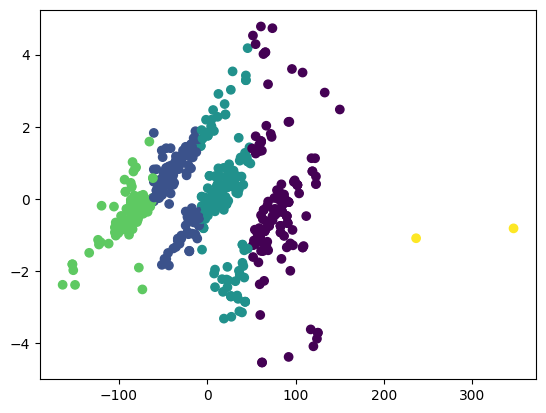

In [1167]:
#visualizar si los clusters estan bien hechos
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

pca.fit(train_dummies)

pca.transform(train_dummies)

#visualizar los clusters
import matplotlib.pyplot as plt
plt.scatter(pca.transform(train_dummies)[:,0], pca.transform(train_dummies)[:,1], c=kmeans.predict(train_dummies))

#ver si los clusters estan bien hechos

In [1172]:
#ver si los clusters estan bien hechos
test_dummies = pd.get_dummies(test_nolabel)

In [1180]:
rf = ExtraTreesClassifier(n_estimators=100, random_state=42)
#'ExtraTreesClassifier' object has no attribute 'named_steps', modelos que tengan named_steps son: pipeline, gridsearchcv, randomsearchcv, columntransformer, pipel
gd_rf = GridSearchCV(rf, {"n_estimators": [100],"max_depth": [5]}, cv=5, n_jobs=-1)
gd_rf.fit(train_dummies, smog)

GridSearchCV(cv=5, estimator=ExtraTreesClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [5], 'n_estimators': [100]})

In [1192]:
#sklearn.tree.export_graphviz
from sklearn.tree import export_graphviz
from sklearn import tree

rf = tree.DecisionTreeClassifier()
dot_data = rf.fit(train_dummies, smog)
from IPython.display import display
display(tree.export_graphviz(model))

#pydotplus
import pydotplus#pip install pydotplus


# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)  

# Show graph
Image(graph.create_png())

'digraph Tree {\nnode [shape=box, fontname="helvetica"] ;\nedge [fontname="helvetica"] ;\n0 [label="x[4] <= 212.5\\ngini = 0.761\\nsamples = 586\\nvalue = [33, 125, 197, 112, 119]"] ;\n1 [label="x[63] <= 0.5\\ngini = 0.552\\nsamples = 138\\nvalue = [0, 10, 30, 12, 86]"] ;\n0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;\n2 [label="x[73] <= 0.5\\ngini = 0.515\\nsamples = 120\\nvalue = [0, 9, 19, 12, 80]"] ;\n1 -> 2 ;\n3 [label="x[77] <= 0.5\\ngini = 0.496\\nsamples = 117\\nvalue = [0, 8, 17, 12, 80]"] ;\n2 -> 3 ;\n4 [label="x[44] <= 0.5\\ngini = 0.458\\nsamples = 105\\nvalue = [0, 7, 16, 7, 75]"] ;\n3 -> 4 ;\n5 [label="x[2] <= 8.65\\ngini = 0.397\\nsamples = 84\\nvalue = [0, 3, 10, 7, 64]"] ;\n4 -> 5 ;\n6 [label="x[56] <= 0.5\\ngini = 0.156\\nsamples = 36\\nvalue = [0, 0, 2, 1, 33]"] ;\n5 -> 6 ;\n7 [label="x[45] <= 0.5\\ngini = 0.109\\nsamples = 35\\nvalue = [0, 0, 1, 1, 33]"] ;\n6 -> 7 ;\n8 [label="x[21] <= 0.5\\ngini = 0.064\\nsamples = 30\\nvalue = [0, 0, 0, 1, 29]"] ;\

TypeError: object of type 'DecisionTreeClassifier' has no len()

In [1217]:
test_final['Smog'] =smog_1

In [1218]:
#convertir en smog los 0 en 1 y los 1 n 0
test_final['Smog'] = test_final['Smog'].apply(lambda x: 9 if x==0 else x)

In [1219]:
test_final['Smog'] = test_final['Smog'].apply(lambda x: 0 if x==1 else x)

In [1220]:
test_final['Smog'] = test_final['Smog'].apply(lambda x: 1 if x==9 else x)

In [1221]:
test_final

,Model Year,Make,Model,Vehicle Class,Engine Size(L),Cylinders,Transmission,Fuel Type,Fuel Consumption (City (L/100 km),Fuel Consumption(Hwy (L/100 km)),Fuel Consumption(Comb (L/100 km)),Fuel Consumption(Comb (mpg)),CO2 Emissions(g/km),Smog Rating,Smog
0,2022,Acura,ILX,Compact,2.4,4,AM8,Z,9.9,7.0,8.6,33,200,3,1
1,2022,Acura,MDX SH-AWD,SUV: Small,3.5,6,AS10,Z,12.6,9.4,11.2,25,263,5,2
2,2022,Acura,RDX SH-AWD,SUV: Small,2.0,4,AS10,Z,11.0,8.6,9.9,29,232,6,3
3,2022,Acura,RDX SH-AWD A-SPEC,SUV: Small,2.0,4,AS10,Z,11.3,9.1,10.3,27,242,6,3
4,2022,Acura,TLX SH-AWD,Compact,2.0,4,AS10,Z,11.2,8.0,9.8,29,230,7,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
941,2022,Volvo,XC40 T5 AWD,SUV: Small,2.0,4,AS8,Z,10.7,7.7,9.4,30,219,5,2
942,2022,Volvo,XC60 B5 AWD,SUV: Small,2.0,4,AS8,Z,10.5,8.1,9.4,30,219,5,2
943,2022,Volvo,XC60 B6 AWD,SUV: Small,2.0,4,AS8,Z,11.0,8.7,9.9,29,232,7,4
944,2022,Volvo,XC90 T5 AWD,SUV: Standard,2.0,4,AS8,Z,11.5,8.4,10.1,28,236,5,2


In [1209]:
train_3 = train.copy()
train_3['Smog'] = smog
train_3[(train_3['Make']=='Porsche')&(train_3['Smog']==1)]

,Make,Vehicle Class,Engine Size (L),Cylinders,Transmission,Fuel Type,Fuel Consumption City (L/100 km),Hwy (L/100 km),CO2 Emissions (g/km),Smog
67,Porsche,Full-size,4.0,8,AM8,Z,15.3,11.2,326,1
75,Porsche,Two-seater,4.0,6,AM7,Z,15.7,12.7,335,1
180,Porsche,Full-size,4.0,8,AM8,Z,15.3,11.2,326,1
191,Porsche,SUV: Standard,4.0,8,AS8,Z,15.9,12.0,330,1
224,Porsche,Two-seater,4.0,6,M6,Z,16.9,13.1,354,1
388,Porsche,SUV: Standard,4.0,8,AS8,Z,15.8,12.3,331,1
404,Porsche,SUV: Standard,4.0,8,AS8,Z,16.8,12.4,343,1
463,Porsche,SUV: Standard,4.0,8,AS8,Z,16.8,12.4,345,1
530,Porsche,Two-seater,4.0,6,M6,Z,17.0,13.1,355,1


In [ ]:
train.drop(['Smog'], axis=1, inplace=True)

In [ ]:
test_final.drop(['Smog','Model','Co'], axis=1, inplace=True)

In [1211]:
rf = Pipeline([
    ("preprocessor", preprocessor),
    ("rf", RandomForestClassifier(n_estimators=100, random_state=69, max_depth=8, max_features='log2', criterion='entropy'))
])

rf.fit(train, smog)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Make', 'Vehicle Class',
                                                   'Transmission',
                                                   'Fuel Type']),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Engine Size (L)',
                                                   'Cylinders',
                                                   'Fuel Consumption City '
                                                   '(L/100 km)',
                                                   'Hwy (L/100 km)',
                                                   'CO2 Emissions (g/km)'])])),
                ('rf',
                 RandomForestClassifier(criterion='entropy', max_depth=8,
                                        max_features='log2',
                                        random_state=69))])

In [ ]:
f1_score(smog, rf.predict(train), average='macro')

In [ ]:
from randomDigraphs import RandomDigraph#pip install randomDigraphs
dg = RandomDigraph(order=5,arcProbability=0.5,seed=101)

In [1187]:
dia

'digraph Tree {\nnode [shape=box, fontname="helvetica"] ;\nedge [fontname="helvetica"] ;\n0 [label="x[4] <= 212.5\\ngini = 0.761\\nsamples = 586\\nvalue = [33, 125, 197, 112, 119]"] ;\n1 [label="x[63] <= 0.5\\ngini = 0.552\\nsamples = 138\\nvalue = [0, 10, 30, 12, 86]"] ;\n0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;\n2 [label="x[73] <= 0.5\\ngini = 0.515\\nsamples = 120\\nvalue = [0, 9, 19, 12, 80]"] ;\n1 -> 2 ;\n3 [label="x[77] <= 0.5\\ngini = 0.496\\nsamples = 117\\nvalue = [0, 8, 17, 12, 80]"] ;\n2 -> 3 ;\n4 [label="x[44] <= 0.5\\ngini = 0.458\\nsamples = 105\\nvalue = [0, 7, 16, 7, 75]"] ;\n3 -> 4 ;\n5 [label="x[2] <= 8.65\\ngini = 0.397\\nsamples = 84\\nvalue = [0, 3, 10, 7, 64]"] ;\n4 -> 5 ;\n6 [label="x[56] <= 0.5\\ngini = 0.156\\nsamples = 36\\nvalue = [0, 0, 2, 1, 33]"] ;\n5 -> 6 ;\n7 [label="x[26] <= 0.5\\ngini = 0.109\\nsamples = 35\\nvalue = [0, 0, 1, 1, 33]"] ;\n6 -> 7 ;\n8 [label="x[4] <= 179.0\\ngini = 0.064\\nsamples = 30\\nvalue = [0, 0, 0, 1, 29]"] ;

In [1233]:
#quiero leer saldi y que ponga las columnas trai.columns
train_saldi = pd.read_csv('saldi.csv')


In [1241]:
smog = train['Smog']
train = train.drop(['id'], axis=1)

In [1242]:
train_saldi.columns = train.columns

In [1243]:
train_saldi = train_saldi.drop(['Model','Comb (L/100 km)','Comb (mpg)'], axis=1)
train = train.drop(['Model','Comb (L/100 km)','Comb (mpg)'], axis=1)

In [1248]:
smog = train['Smog']
smog_saldi = train_saldi['Smog']
train = train.drop(['Smog'], axis=1)
train_saldi = train_saldi.drop(['Smog'], axis=1)

In [1302]:
rf = Pipeline([
    ("preprocessor", preprocessor),
    ("rf", ExtraTreesClassifier(n_estimators=100, random_state=42,class_weight='balanced',))
])

rf.fit(train, smog)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Make', 'Vehicle Class',
                                                   'Transmission',
                                                   'Fuel Type']),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Engine Size (L)',
                                                   'Cylinders',
                                                   'Fuel Consumption City '
                                                   '(L/100 km)',
                                                   'Hwy (L/100 km)',
                                                   'CO2 Emissions (g/km)'])])),
                ('rf',
                 ExtraTreesClassifier(class_weight='balanced',
                                      random_state=42))])

In [1303]:
f1_score(smog_saldi, rf.predict(train_saldi), average='macro')

0.9465853840811645

In [1269]:
test = test_nolabel.copy()
test['id'] = id
csv(rf.predict(test_nolabel),'saldi_modelo.csv',test)

In [1254]:
#confusion matrix
confusion_matrix(X_train, rf.predict(train_saldi))

array([[ 57,   0,   0,   0,   0],
       [  0, 181,  14,   0,   3],
       [  0,   2, 287,   9,  10],
       [  0,   0,   8, 178,   3],
       [  0,   2,   7,   3, 182]], dtype=int64)

In [1270]:
y_pred = pd.read_csv('saldi_modelo.csv')
y_1 = pd.read_csv('extra_tree.csv')

In [1271]:
f1_score(y_pred['Predicted'], y_1['Predicted'], average='macro')

0.8397173665951625

In [1295]:
model1 =DecisionTreeClassifier()
model2 = DecisionTreeClassifier()

In [1296]:
train_saldi_dummies = pd.get_dummies(train_saldi)
train_dummies = pd.get_dummies(train)

In [1297]:
model1.fit(train_dummies, smog)
model2.fit(train_saldi_dummies, smog_saldi)

DecisionTreeClassifier()

In [ ]:
model

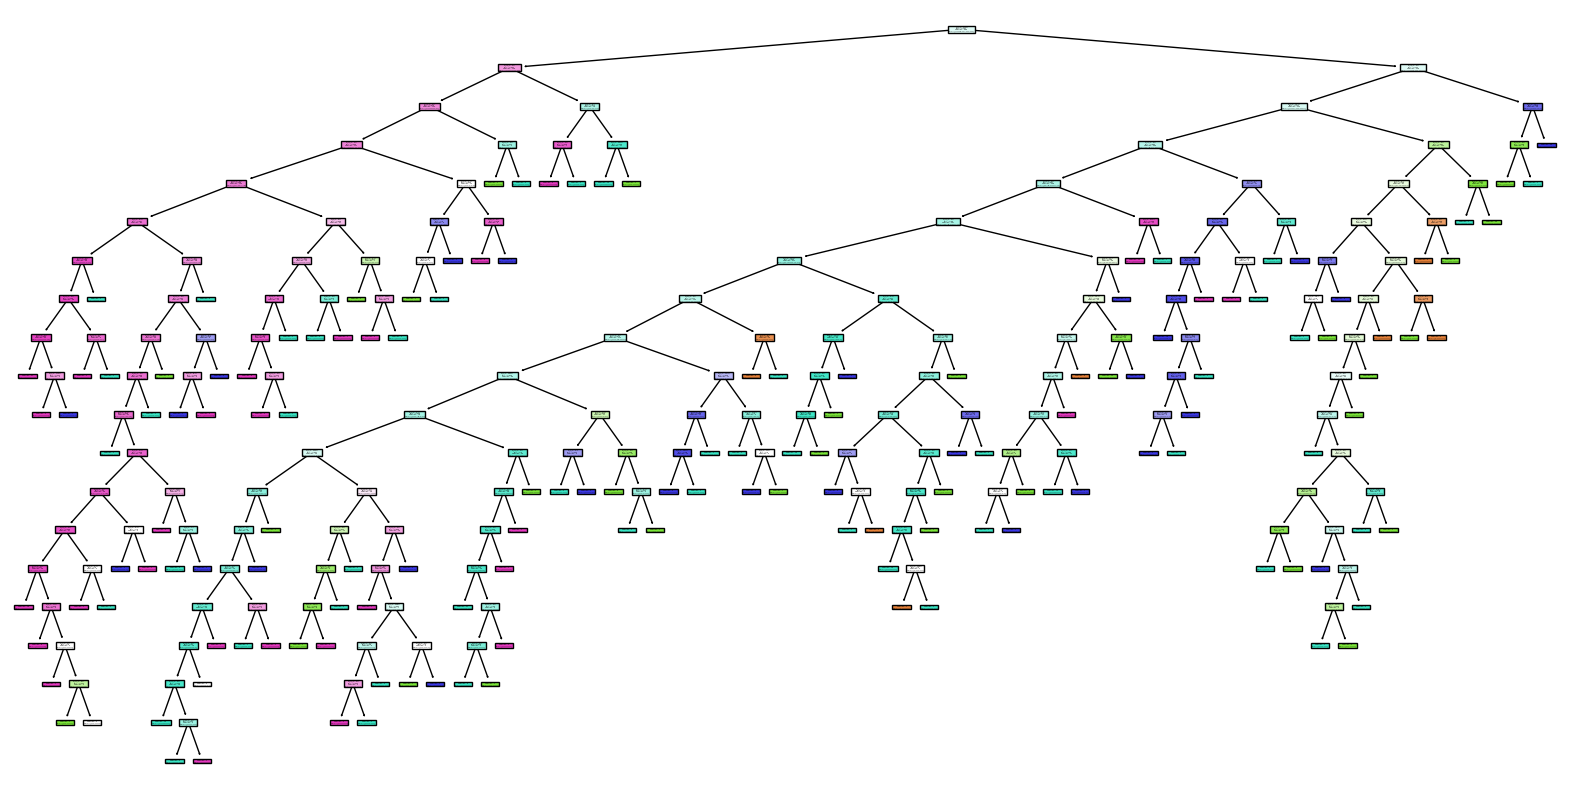

In [1288]:
#quiero observar como se ha ajustado rf
# es decir quiero observar los arboles que ha creado

#sklearn.tree.export_graphviz


from sklearn.tree import ExtraTreeClassifier
from sklearn.datasets import load_iris
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 10))
plot_tree(model, filled=True, feature_names=None, class_names=None)
plt.show()

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 2 with shape (85,) and arg 3 with shape (4,).

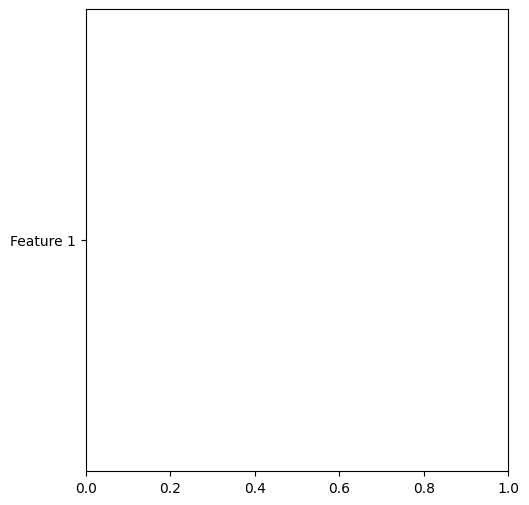

In [1299]:
feature_importance1 = model1.feature_importances_
feature_importance2 = model2.feature_importances_

# Nombres de las características (si tienes acceso a ellos)
feature_names = ["Feature 1", "Feature 2", "Feature 3", "Feature 4"]

# Plotea la importancia de las características para ambos modelos
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(feature_names, feature_importance1)
plt.title('Feature Importance (Model 1)')
plt.xlabel('Importance')

plt.subplot(1, 2, 2)
plt.barh(feature_names, feature_importance2)
plt.title('Feature Importance (Model 2)')
plt.xlabel('Importance')

plt.tight_layout()
plt.show()


In [1416]:
rf =Pipeline([
    ("preprocessor", preprocessor),
    ("rf", RandomForestClassifier(n_estimators=100, random_state=88,class_weight='balanced'))
])

rf_42 =Pipeline([
    ("preprocessor", preprocessor),
    ("rf", RandomForestClassifier(n_estimators=100, random_state=42,class_weight='balanced'))
])

rf_100 =Pipeline([
    ("preprocessor", preprocessor),
    ("rf", RandomForestClassifier(n_estimators=100, random_state=100,class_weight='balanced'))])

extra_tree = Pipeline([
    ("preprocessor", preprocessor),
    ("et", ExtraTreesClassifier(n_estimators=100, random_state=82,class_weight='balanced'))
])


svc = Pipeline([
    ("preprocessor", preprocessor),
    ("svc", SVC(class_weight='balanced', random_state=42)),
])

gd = Pipeline([
    ("preprocessor", preprocessor),
    ("gd", GradientBoostingClassifier(random_state=42)),
])

bagging = Pipeline([
    ("preprocessor", preprocessor),
    ("bagging", BaggingClassifier(n_estimators=100, random_state=42))
])
#HistGradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
'''

hist_gd = Pipeline([
    ("preprocessor", preprocessor),
    ("hist_gd", HistGradientBoostingClassifier(random_state=42)),
])
'''
estimators = [
    ('bagging', bagging),
    ('svc', svc),
    ('extra_tree', extra_tree),

]

from sklearn.naive_bayes import MultinomialNB

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

stack = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(solver='saga'), n_jobs=-1)

In [1417]:
test_saldi = pd.read_csv('comprobar.csv')

In [1418]:
stack.fit(train, smog)

c:\Users\andre\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


StackingClassifier(estimators=[('bagging',
                                Pipeline(steps=[('preprocessor',
                                                 ColumnTransformer(transformers=[('cat',
                                                                                  Pipeline(steps=[('ohe',
                                                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                                                  ['Make',
                                                                                   'Vehicle '
                                                                                   'Class',
                                                                                   'Transmission',
                                                                                   'Fuel '
                                                                                   'Type']),
                                                                                 ('num',
                                                                                  Pipeline(steps=[('scaler',
                                                                                                   StandardScaler())]),
                                                                                  ['Engine '
                                                                                   'Size '
                                                                                   '(L)',
                                                                                   'Cylinders',
                                                                                   'Fuel '
                                                                                   'Consumption '
                                                                                   'City '
                                                                                   '(L/10...
                                                                                   'Vehicle '
                                                                                   'Class',
                                                                                   'Transmission',
                                                                                   'Fuel '
                                                                                   'Type']),
                                                                                 ('num',
                                                                                  Pipeline(steps=[('scaler',
                                                                                                   StandardScaler())]),
                                                                                  ['Engine '
                                                                                   'Size '
                                                                                   '(L)',
                                                                                   'Cylinders',
                                                                                   'Fuel '
                                                                                   'Consumption '
                                                                                   'City '
                                                                                   '(L/100 '
                                                                                   'km)',
                                                                                   'Hwy '
                                                                                   '(L/100 '
                                                                                   'km)',
                                         

In [1419]:
predictions = stack.predict(test_nolabel)

In [1420]:
f1_score(test_saldi['Predicted'], predictions, average='macro')

0.8515647695832378

In [1421]:
predicciones = stack.predict(test_nolabel)

In [1422]:
csv(predicciones,'saldi_salsa.csv',test)

In [1352]:
len(train)+len(test_nolabel)

976

In [1427]:
test = pd.read_csv('rf_svm_logreg.csv')
predictions = pd.read_csv('comprobar.csv')

In [1428]:
f1_score(test['Predicted'], predictions['Predicted'], average='macro')

0.8682249188588089